In [1]:
# analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('darkgrid')
np.set_printoptions(precision=3)
warnings.filterwarnings("ignore")

# missings (imputer)
# from sklearn.impute import SimpleImputer, KNNImputer

# interacciones
from sklearn.preprocessing import PolynomialFeatures

# transformaciones
from sklearn.compose import ColumnTransformer
# - variab numéricas
from sklearn.preprocessing import RobustScaler # MinMaxScaler, StandardScaler, Normalizer, Binarizer 
# from sklearn.preprocessing import PowerTransformer, BoxCox
# - variab categ
from sklearn.preprocessing import OneHotEncoder # LabelEncoder, OrdinalEncoder

# feature selection
from sklearn.feature_selection import f_classif # chi2
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import RFE, RFECV
# from sklearn.decomposition import PCA

# algoritmos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier # red neuronal

# bagging
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier

# boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
# import xgboost as xgb

# Stacking:
from sklearn.ensemble import StackingClassifier

# model selection
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.pipeline import Pipeline # make_pipeline
from sklearn.model_selection import GridSearchCV # RandomizedSearchCV
from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, ParameterGrid

# Técnicas de evaluación
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, RocCurveDisplay

In [2]:
# semilla de aleatorización

seed = 99

In [3]:
data = pd.read_csv('Datasets/datos_procesados.csv')

print(f'Número de filas: {data.shape[0]}, Númerode columnas:{data.shape[1]}')

Número de filas: 4687, Númerode columnas:24


In [4]:
# Separar en train y test
X_train = data[data['Dataset'] == 'train'].drop(['Dataset'], axis=1)
X_test = data[data['Dataset'] == 'test'].drop(['Dataset'], axis=1)

# variable objetivo (.pop elimina la col de X, que también es un paso necesario)
y_train = X_train.pop('Hazardous')
y_test = X_test.pop('Hazardous')

In [5]:
# SMOTE (remuestro de datos de entrenamiento desbalanceados)

# Probaremos a obtener el mejor modelo tanto con los train_data desbalanceados como balanceados con smote

categ_index = X_train.columns.get_loc('Orbit Uncertainity (categ)')

smote_nc = SMOTENC(categorical_features=[categ_index], # hay que indicarle cuál es la variab categ en el dataset que se va a transformar
             random_state=seed)

X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

In [24]:
# Definir los clasificadores base
clf1 = LogisticRegression(max_iter=100,
                          penalty='l1',
                          C= 0.1,
                          solver='liblinear',
                          class_weight='balanced',
                          random_state=seed)

clf2 = DecisionTreeClassifier(criterion='gini',
                              max_features='sqrt',
                              max_depth=7,
                              min_samples_leaf=30,
                              class_weight='balanced',
                              random_state=seed)

clf3 = SVC(kernel='rbf',
           C=1,
           gamma=0.1,
           class_weight='balanced',
           random_state=seed)

# Definir el clasificador de nivel superior (meta-classifier)
meta_clf = LogisticRegression(class_weight='balanced', random_state=seed)

# Crear el clasificador de stacking
model = StackingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('svm', clf3)],
    final_estimator=meta_clf
)

In [7]:
import time
start_time = time.time()

# Definir variabs numéricas y categóricas
scaler_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categ_features = [feature for feature in X_train.columns if feature not in scaler_features]

col_transformer = ColumnTransformer(
    [
    ('encoder', OneHotEncoder(drop=["3-9"]), ['Orbit Uncertainity (categ)']),
    ('scaler', RobustScaler(), scaler_features)
    ], remainder='passthrough')

# # Definir instancia SMOTENC (se puede o bien definir fuera y pasar X_train_resampled, o bien definir aquí y pasar X_train)
# categ_index = X_train.columns.get_loc('Orbit Uncertainity (categ)')
# smote_nc = SMOTENC(categorical_features=[categ_index], # hay que indicarle cuál es la variab categ en el dataset que se va a transformar
#              random_state=seed)

# # Pipeline 1
# pipe = Pipeline([
# #         ('smote_nc', smote_nc), # quitarlo si class_weight='balanced'
#         ('column_transform', col_transformer),
#         ('polynomial', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), # añadir interacciones
#         ('algorithm', model)        
# ])

# # Tuneado del modelo (malla de paráms) --> ajustaremos SOLO los del meta_clf (los demás ya están)
# parametros = {
#     "algorithm__final_estimator__penalty": [None,'l1','l2'],
#     "algorithm__final_estimator__C": [0.1, 1.0, 10.0],
#     "algorithm__final_estimator__solver": ['lbfgs','liblinear']
# }

# Repeated cross_val (stratified)
# cv_technique = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_technique = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)
   
# # combinamos todo
# gsearch = GridSearchCV(estimator=pipe, cv=cv_technique, param_grid=parametros, scoring='f1') # (*)

# # buscamos el mejor modelo
# # grid_model = gsearch.fit(X_train, y_train) # sin resample
# grid_model = gsearch.fit(X_train_resampled, y_train_resampled) # con SMOTE resample

# print("Best CV score:", grid_model.best_score_)

end_time = time.time()
print()
print("Tiempo de ejecución:", end_time - start_time, "segundos")

KeyboardInterrupt: 

In [ ]:
# Mejor estimador
# grid_model.best_estimator_.named_steps['algorithm']

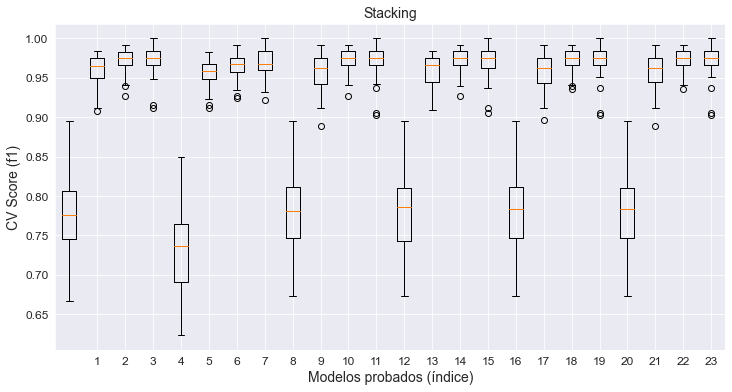


Tiempo de ejecución: 1034.6684787273407 segundos


In [17]:
# Pipeline 2: feature selection (cross_val_score)
# Repetir la cross_val, pero guardando los scores para poder representarlos y
# además, haciendo feature selection basada en f_classif

import time
start_time = time.time()

pipe_fs = Pipeline([
#         ('smote_nc', smote_nc), # quitarlo si class_weight='balanced'
        ('column_transform', col_transformer),
        ('polynomial', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), # añadir interacciones
        ('feature_selection', SelectKBest(score_func=f_classif)), # k = número de variabs a seleccionar
#         ('algorithm', grid_model.best_estimator_.named_steps['algorithm'])        
        ('algorithm', model)
]) # importante: meter el mejor algorithm obtenido antes

parametros_fs = {
    "feature_selection__k": [3,4,5,6],
    "algorithm__final_estimator__penalty": ['l1','l2'],
    "algorithm__final_estimator__C": [0.1, 1.0, 10.0],
    "algorithm__final_estimator__solver": ['liblinear']
}

# Cambiar el formato de la malla de parámetros para poder usarlos en el bucle for
grid_params = list(ParameterGrid(parametros_fs)) # lista de diccionarios

cv_scores = []
for params in grid_params:
    # Configurar los parámetros del pipeline
    pipe_fs.set_params(**params)
    
    # Calcular los scores
    scores = cross_val_score(pipe_fs,
                             X_train, y_train, # X_train_resampled, y_train_resampled
                             cv=cv_technique, scoring='f1')
    cv_scores.append(scores)

# boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(cv_scores)
plt.title('Stacking', fontsize=14)
plt.xlabel('Modelos probados (índice)', fontsize=14)
plt.ylabel('CV Score (f1)', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(range(2, len(cv_scores)+1), fontsize=12) # no consigo poner el xtick = 0
plt.show()

end_time = time.time()
print()
print("Tiempo de ejecución:", end_time - start_time, "segundos")

In [18]:
# Comparar mejores
print(grid_params[2])
print(grid_params[6])
print(grid_params[10])
print(grid_params[14])
print(grid_params[18])
print(grid_params[22])

{'algorithm__final_estimator__C': 0.1, 'algorithm__final_estimator__penalty': 'l1', 'algorithm__final_estimator__solver': 'liblinear', 'feature_selection__k': 5}
{'algorithm__final_estimator__C': 0.1, 'algorithm__final_estimator__penalty': 'l2', 'algorithm__final_estimator__solver': 'liblinear', 'feature_selection__k': 5}
{'algorithm__final_estimator__C': 1.0, 'algorithm__final_estimator__penalty': 'l1', 'algorithm__final_estimator__solver': 'liblinear', 'feature_selection__k': 5}
{'algorithm__final_estimator__C': 1.0, 'algorithm__final_estimator__penalty': 'l2', 'algorithm__final_estimator__solver': 'liblinear', 'feature_selection__k': 5}
{'algorithm__final_estimator__C': 10.0, 'algorithm__final_estimator__penalty': 'l1', 'algorithm__final_estimator__solver': 'liblinear', 'feature_selection__k': 5}
{'algorithm__final_estimator__C': 10.0, 'algorithm__final_estimator__penalty': 'l2', 'algorithm__final_estimator__solver': 'liblinear', 'feature_selection__k': 5}


In [19]:
# El mejor modelo es:
k_optimo = 2 # indicar nº óptimo

# Configura el pipeline con los parámetros deseados
pipe_fs.set_params(feature_selection__k=k_optimo)

# Ajusta el modelo
selected_model = pipe_fs.fit(X_train, y_train)
selected_model

# Recuerda: al ajustar con random_state habilitado, las k variabs seleccionadas
# serán las mismas que las seleccionadas en el cross_val_score, por eso sabemos
# que esta forma de seleccionar el mejor modelo es correcta

Pipeline(steps=[('column_transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(drop=['3-9']),
                                                  ['Orbit Uncertainity '
                                                   '(categ)']),
                                                 ('scaler', RobustScaler(),
                                                  ['Est Dia in M(max)',
                                                   'Relative Velocity km per '
                                                   'sec',
                                                   'Miss Dist.(Astronomical)',
                                                   'Minimum Orbit Intersection',
                                                   'Eccentricity',
                                                   'Semi Major Axis',
                                                   'Inclination',
                                                   'Asc Node Longitude...
                                                 LogisticRegression(C=0.1,
                                                                    class_weight='balanced',
                                                                    penalty='l1',
                                                                    random_state=99,
                                                                    solver='liblinear')),
                                                ('rf',
                                                 DecisionTreeClassifier(class_weight='balanced',
                                                                        max_depth=7,
                                                                        max_features='sqrt',
                                                                        min_samples_leaf=30,
                                                                        random_state=99)),
                                                ('svm',
                                                 SVC(C=1,
                                                     class_weight='balanced',
                                                     gamma=0.1,
                                                     random_state=99))],
                                    final_estimator=LogisticRegression(C=10.0,
                                                                       random_state=99,
                                                                       solver='liblinear')))])

In [38]:
pipe_fs.set_params(**{"algorithm__final_estimator__C": 0.1, 
                      "algorithm__final_estimator__solver": 'liblinear', 
                    "algorithm__final_estimator__penalty": 'l1',
                    "algorithm__final_estimator__class_weight": 'balanced'})

selected_model = pipe_fs.fit(X_train, y_train)

In [39]:
# Variables seleccionadas:

ct_names = selected_model.named_steps['column_transform'].get_feature_names_out()
poly_names = selected_model.named_steps['polynomial'].get_feature_names_out(input_features=ct_names)
select_names = selected_model.named_steps['feature_selection'].get_feature_names_out(input_features=poly_names)

print(f"Las {k_optimo} variabs seleccionadas son:")
[i for i in select_names]

Las 2 variabs seleccionadas son:


['encoder__Orbit Uncertainity (categ)_0 scaler__Minimum Orbit Intersection_log',
 'scaler__Est Dia in M(max)_raiz2 scaler__Minimum Orbit Intersection_log']

El valor de f1 score es: 
 0.674
Otros estadísticos del test: 
               precision    recall  f1-score   support

           0       0.95      0.90      0.93       787
           1       0.60      0.77      0.67       151

    accuracy                           0.88       938
   macro avg       0.78      0.84      0.80       938
weighted avg       0.90      0.88      0.89       938



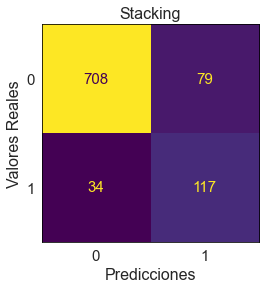

In [40]:
# Score y Confusion Matrix

# Evalúa el mejor modelo en tus datos de prueba
y_pred = selected_model.predict(X_test)

# Calcular la precisión de las predicciones en el conjunto de prueba
print(f"El valor de f1 score es: \n {f1_score(y_test, y_pred).round(3)}")
print(f"Otros estadísticos del test: \n {classification_report(y_test, y_pred)}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap='viridis', values_format='d', colorbar=False)
ax.grid(False) # Deshabilitar el grid de fondo

# plt.title('Matriz de confusión', fontsize=18) # Cambiar tamaño del título
ax.spines[['bottom','top','left','right']].set_color('black')
plt.title('Stacking', fontsize=16)
plt.xlabel('Predicciones', fontsize=16)
plt.ylabel('Valores Reales', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for text in ax.texts:
    text.set_fontsize(15)
plt.show()

In [41]:
import pickle

# Guarda los datos de puntuaciones
with open('cv_scores_model11.pkl', 'wb') as f:
    pickle.dump(cv_scores[k_optimo], f)